In [3]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

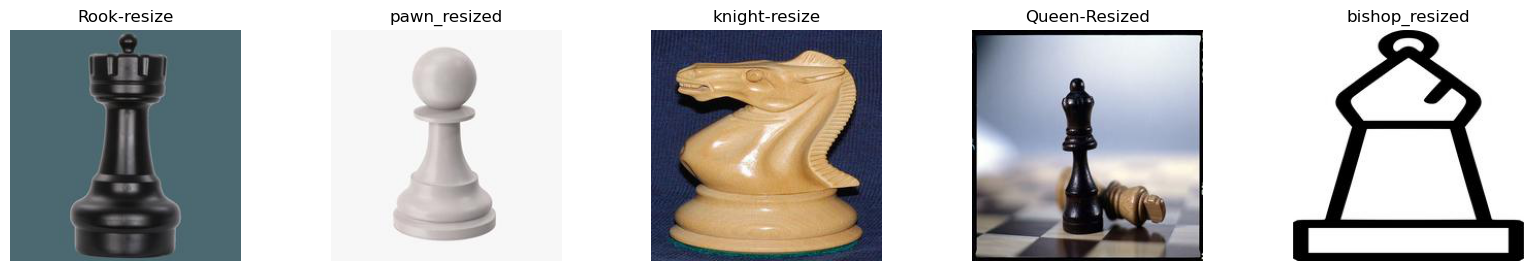

In [4]:
file_path = '/kaggle/input/chess-pieces-detection-images-dataset'
fig, axs = plt.subplots(1,5,figsize=(20,3))
for i,x in enumerate(os.listdir(file_path)):
    img_path = file_path+'/'+ x + '/' + random.choice(os.listdir(file_path+'/'+x))
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(x)
plt.show()

In [5]:
path = '/kaggle/input/chess-pieces-detection-images-dataset'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                         validation_split=.1)
train_data = datagen.flow_from_directory(path,
                                        target_size=(224,224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='training')
test_data = datagen.flow_from_directory(path,
                                        target_size=(224,224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation',
                                       shuffle=False)

Found 588 images belonging to 5 classes.
Found 63 images belonging to 5 classes.


In [6]:
import tensorflow_hub as hub

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=(224,224,3))
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                              patience=3,
                                                              verbose=1,
                                                              factor=.5,
                                                              min_lr=.00001)
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(5,activation='softmax')
])
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = model.fit(train_data,
                   epochs=10,
                   steps_per_epoch=len(train_data),
                   validation_data=test_data,
                   validation_steps=len(test_data))

Epoch 1/10
19/19 [==============================] - 17s 292ms/step - loss: 1.5052 - accuracy: 0.3912 - val_loss: 0.9198 - val_accuracy: 0.6825
Epoch 2/10
19/19 [==============================] - 2s 102ms/step - loss: 0.7998 - accuracy: 0.7075 - val_loss: 0.6025 - val_accuracy: 0.8254
Epoch 3/10
19/19 [==============================] - 2s 103ms/step - loss: 0.5570 - accuracy: 0.8333 - val_loss: 0.4725 - val_accuracy: 0.8413
Epoch 4/10
19/19 [==============================] - 2s 103ms/step - loss: 0.4359 - accuracy: 0.8759 - val_loss: 0.4407 - val_accuracy: 0.8730
Epoch 5/10
19/19 [==============================] - 2s 101ms/step - loss: 0.3596 - accuracy: 0.9082 - val_loss: 0.3640 - val_accuracy: 0.9048
Epoch 6/10
19/19 [==============================] - 2s 108ms/step - loss: 0.3152 - accuracy: 0.9252 - val_loss: 0.3334 - val_accuracy: 0.8730
Epoch 7/10
19/19 [==============================] - 2s 101ms/step - loss: 0.2701 - accuracy: 0.9456 - val_loss: 0.3265 - val_accuracy: 0.8730
Epoch

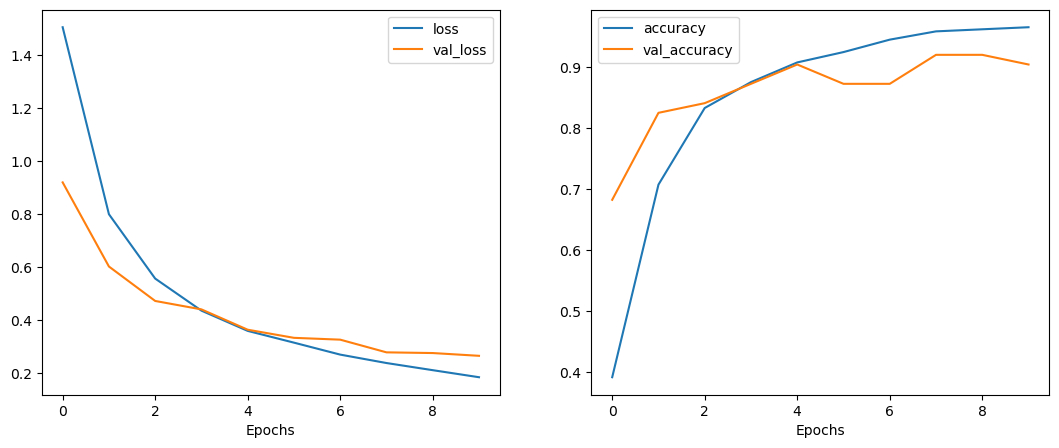

In [7]:
fig, axs = plt.subplots(1,2,figsize=(13,5))
axs[0].plot(pd.DataFrame(history.history)[['loss','val_loss']])
axs[0].set_xlabel("Epochs")
axs[0].legend(['loss','val_loss'])
axs[1].plot(pd.DataFrame(history.history)[['accuracy','val_accuracy']])
axs[1].set_xlabel("Epochs")
axs[1].legend(['accuracy','val_accuracy'])

In [8]:
from sklearn.metrics import classification_report
y_pred = tf.argmax(model.predict(test_data),axis=1)
classes = list(test_data.class_indices.keys())
pred_classes = [classes[x] for x in y_pred]
labels_classes = [classes[x] for x in test_data.labels]
print(classification_report(labels_classes,pred_classes))

2/2 [==============================] - 1s 102ms/step
                precision    recall  f1-score   support

 Queen-Resized       0.73      1.00      0.85        11
   Rook-resize       1.00      0.85      0.92        13
bishop_resized       0.86      0.86      0.86        14
 knight-resize       1.00      1.00      1.00        17
  pawn_resized       1.00      0.75      0.86         8

      accuracy                           0.90        63
     macro avg       0.92      0.89      0.90        63
  weighted avg       0.92      0.90      0.91        63



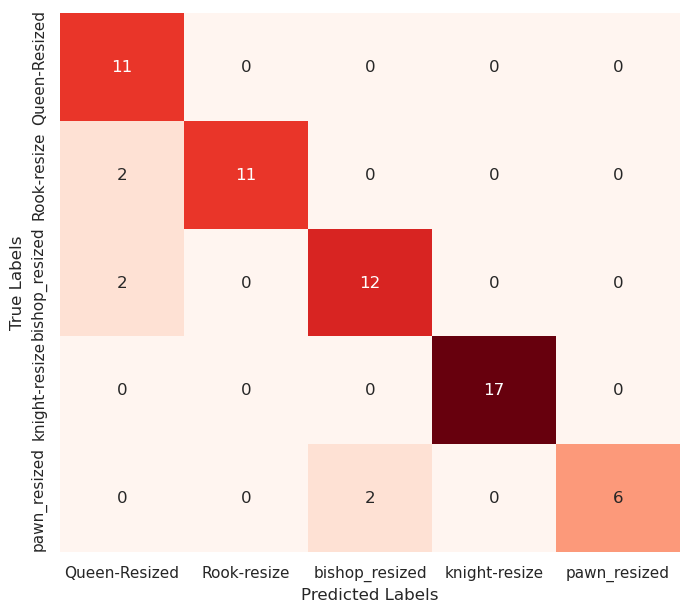

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(labels_classes,pred_classes)
sns.set_theme(rc={'figure.figsize':(8,7)})
ax = sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=classes,yticklabels=classes,cbar=False)
ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels');